# Données routières manquantes pour la DGITM
## Retour sur l’approche suivie à RSTAnalytics
### Pierre-Cyril Aubin, 02/07/2018
##### Description du défi
Réseau routier national : Boucher les trous… dans les données. Trouver un algorithme pour compléter les données manquantes dans les données trafic (suite à des pannes des boucles de comptages)

##### Description des données
Pour 5316 segments de route, nous disposons d’une mesure pour les six dernières années, dont celle la plus récente (2015). Des données de ce type sont disponibles sur https://www.data.gouv.fr/fr/datasets/trafic-moyen-journalier-annuel-sur-le-reseau-routier-national/#_

- Proportion des trous : 56,4% des segments ont au moins une valeur manquante à compléter. 15,6% n’ont pas de valeur du tout.
- Longueur des chroniques : elles sont très courtes, seulement six valeurs, une valeur manquante a donc beaucoup d’incidence.
- Données agrégées traduisant des tendances lourdes (sans cycles saisonniers), il n’y a pas de régularité particulière des chroniques.

Pour les segments sans aucune valeur de trafic, mis à part un raisonnement géospatial ad hoc, il n’y a pas de méthode miracle.


### Approches algorithmiques en fonction de l’échelle

Le problème se ramène à une complétion de données manquantes dans des chroniques. Les données sont à valeurs positives. On peut distinguer trois approches :
- Exclusivement locale : On n’utilise que l’information du segment considéré (valeur moyenne, interpolation,...)
- Locale : On s’appuie sur l’information des segments proches pour trouver des formes communes d’évolution ou pour une interprétation géospatiale. 
- Globale : On utilise conjointement toutes les informations. Il s’agit d’une simple extension des méthodes locales.

Très peu d’algorithmes de complétion ont été codés dans la bibliothèque scikit-learn (http://scikit-learn.org/dev/modules/impute.html).
Un peu de théorie sur l’imputation de données, en français : http://wikistat.fr/pdf/st-m-app-idm.pdf

### Approche NMF: Factorisation par matrices non négatives

Présentation de NMFen français : https://www.math.univ-toulouse.fr/~besse/Wikistat/pdf/st-m-explo-nmf.pdf

On considère les données comme une matrice (indice de la route x nombre de dates). On cherche des vecteurs d’évolution “standards” à partir des données sans trous qui servent de base aux remplissage des données à trous.C’est une approche agnostique dans la mesure où aucune géométrie particulière du réseau n’est considérée. Le code commenté est sur : https://github.com/PCAubin/DGITM
Il s’agit plus exactement de définir automatiquement pour chaque regroupement de segments (par le nom de la route, ex : A0001) une grammaire de formes d’évolution par du “dictionary learning”.  Il aurait aussi été possible de trouver des segments ayant connu le même type d’évolution et d’utiliser une méthode de plus proches voisins. Mais cela aurait signifié de standardiser les données, qui auraient perdu leur positivité (plus d’algorithme NMF), et de les représenter par leurs variations.

Ce code utilise quatre bibliothèques classiques de python : numpy, matplotlib, pandas et sklearn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Le fichier complet de trafic a été réduit aux colonnes : tmja (trafic moyen journalier annuel), début et fin des segments en coordonées (x,y) et identifiant des routes. IDRoute permet d'itérer sur les identifiants, SelectedRoute d'en sélectionner une par son nom, segment de se restreindre à une liste de lignes.

__df__ contient le tableau complet.

__df_tmja__ contient le tableau restreint au segment.

__df_tmja_wo_zeros_rows__ contient le tableau restreint au segment et aux lignes avec au moins une valeur.

__df_tmja_wo_zeros__ contient le tableau restreint au segment et aux lignes sans trous.

In [3]:
PATH=''
name='TMJA_MTES_DGITM_traficroutier_2015-01-01_small.csv'
df=pd.read_csv(PATH+name, delimiter=',')

tmja_cols= [col for col in df.columns if 'tmja' in col]
#df_small=df[['route']+['xD','yD','xF','yF']+tmja_cols]

segment=np.arange(3319,3359)
IDroute=df['route'].unique()
SelectedRoute='N0088'
#df_small.to_csv('TMJA_MTES_DGITM_traficroutier_2015-01-01_small.csv', index=False)
df_tmja=df[tmja_cols].loc[df['route']==SelectedRoute]
#df_tmja=df[tmja_cols].iloc[segment]
df_tmja=df_tmja.replace(0,float('NaN'))
df_tmja_wo_zeros_rows=df_tmja[~(df_tmja.sum(axis=1)==0)]
df_tmja_wo_zeros=df_tmja_wo_zeros_rows.dropna()

L'algorithme NMF est très dépendant de sa méthode d'initialisation (init). n_components doit être plus petit que les deux dimensions de la matrice (au plus égal à 5 ici). Deux composantes suffisent de manière générale.

NMF renvoie deux matrices W et H, H contient les (deux) formes caractéristiques d'évolution, W contient les pondérations des formes pour chaque ligne. NMF est utilisé sur les lignes sans aucun trou du segment, pour être ensutie étendu aux lignes à donénes manquantes.

$$A\approx W*H$$

Les (deux) lignes de H sont ensuite ramenées à la norme 1.

In [4]:
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize

df_tmja_wo_zeros_comp=df_tmja_wo_zeros_rows.copy()

model = NMF(n_components=2,init='nndsvdar',max_iter=1000)
W = model.fit_transform(df_tmja_wo_zeros)
H = model.components_

Hnorm=normalize(H)

On peut représenter les (deux) formes caractéristiques (__Hnorm[0]__ et __Hnorm[1]__). Le plus souvent une est croissante et l'autre décroissante.

Populating the interactive namespace from numpy and matplotlib


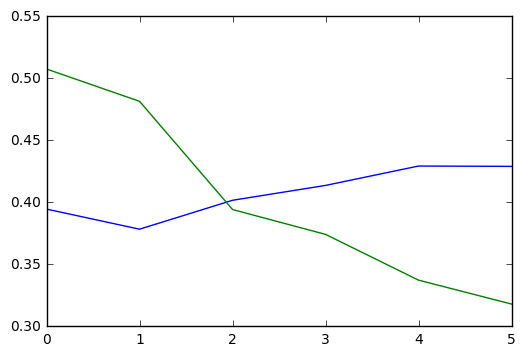

In [5]:
% pylab inline
#plt.figure()
plt.plot(Hnorm.T)

Il faut ensuite compléter les lignes manquantes en les projetant sur les formes caractéristiques. Le choix fait ici est d'utiliser le produit scalaire $L_2$, mais il est loin d'être justifié. En effet toutes les données sont à valeurs positives, le produit scalaire n'a donc que très peu de chances d'être nul. Qui plus est la base n'est pas orthogonale ce qui demande des correctifs.

Il n'était pas possible de retirer la moyenne avant d'appliquer NMF. Cependant ce serait maintenant une option pour ne traiter que des variations par rapport à la moyenne.

Nonobstant ces limites, pour une ligne à compléter avec N trous (représentée par un vecteur __u__$\;\in\;E:=\mathbb{R}^{N-6}$), nous transformons les formes (__Hnorm[0]__,__Hnorm[1]__$\;\in\; \mathbb{R}^6$) en deux vecteurs de norme 1 (__a__,__b__$\;\in\; E:=\mathbb{R}^{N-6}$). Nous projetons ensuite __u__ sur la base (__a__,__b__) :

$$ \mathbf{u}=\alpha \cdot \mathbf{a} + \beta \cdot \mathbf{b}$$
Comme __a__ et __b__ peuvent être très fortement corrélés (en dimension 1, pour N=5, c'est toujours le cas), $\alpha$ et $\beta$ peuvent être très grands de façon à se compenser (système mal conditionné), c'est pourquoi nous utilisons $\frac{|\alpha+\beta|}{2}$ pour reconstituer la ligne complète (représentée par un vecteur __v__$ \in  \mathbb{R}^{6}$ tel que __v__|$_E$=__u__)

$$ \mathbf{v}|_{E^C}=\frac{|\alpha+\beta|}{2 \|a\|_E} \cdot \mathbf{Hnorm[0]}|_{E^C} + \frac{|\alpha+\beta|}{2\|b\|_E} \cdot \mathbf{Hnorm[1]}|_{E^C}$$

Il faut aussi tenir du fait que (__Hnorm[0]__,__Hnorm[1]__) et (__a__,__b__) n'appartiennent pas au même espace et ne sont donc pas normalisés dans les mêmes bases.

In [6]:
from itertools import compress
for i in(list(compress(range(0,df_tmja_wo_zeros_comp.shape[0]+1),
                  df_tmja_wo_zeros_rows.isnull().any(axis=1).values))):
    testline=df_tmja_wo_zeros_rows.iloc[i]
    mean_ref=testline.mean()
    testline=testline.replace(float('NaN'),0)
    (a,anorm)=normalize(~(testline.values==0)*Hnorm[0].reshape(1,-1), return_norm=True)
    anorm=anorm[0]
    a=a[0]
    (b,bnorm)=normalize(~(testline.values==0)*Hnorm[1].reshape(1,-1), return_norm=True)
    bnorm=bnorm[0]
    b=b[0]
    ua=np.dot(testline.values,a)
    ub=np.dot(testline.values,b)
    ab=np.dot(a,b)
    if ab!=1:
        alpha=(ua-ub*ab)/(1-ab**2)
        beta=(ub-ua*ab)/(1-ab**2)
    else:
        alpha=ua/2
        beta=ub/2     
#    u=alpha*a+beta*b
    testline_comp=(abs(alpha+beta))/2*Hnorm[0]/anorm+(abs(alpha+beta))/2*Hnorm[1]/bnorm
    df_tmja_wo_zeros_comp.iloc[i]=testline_comp#/testline_comp.mean()*mean_ref
    
df_tmja_wo_zeros_comp[~df_tmja_wo_zeros_rows.isnull()]=df_tmja_wo_zeros_rows


Une fois les chorniques complétées, on peut comparer visuellement les résultats pour estimer la qualité de la méthode

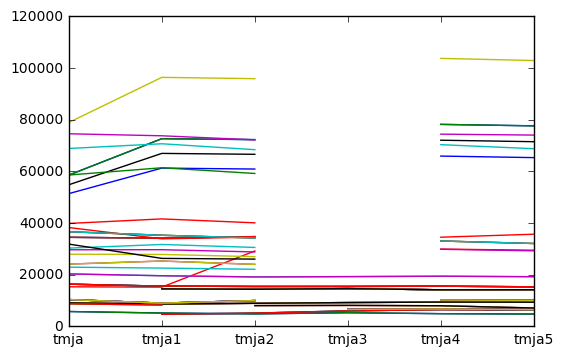

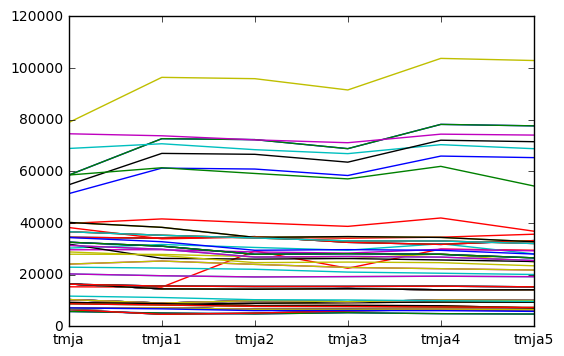

In [9]:
#% pylab inline
df_tmja_wo_zeros_rows.transpose().plot()
lgd=plt.legend()
lgd.set_visible(False)
df_tmja_wo_zeros_comp.transpose().plot()
lgd=plt.legend()
lgd.set_visible(False)

De manière plus anecdotique, on peut aussi afficher dans python un graphe du réseau, coloré en fonction de la densité de traffic.

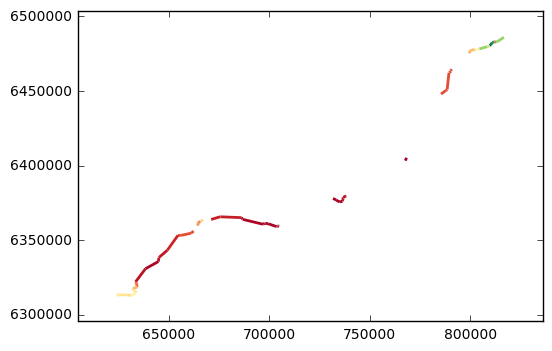

In [8]:
df_segments=(df[['xD','yD','xF','yF']].iloc[df_tmja_wo_zeros_rows.index]
             .apply(lambda x: x.str.replace(',','.')).apply(pd.to_numeric))
cmap = plt.cm.get_cmap('RdYlGn')

ArrColour = np.random.random((df_segments.shape[0], 4))

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
ScaledFluxes=scaler.fit_transform(df_tmja_wo_zeros_comp['tmja'].values.reshape(-1, 1))
#ArrColour=map(plt.cm.jet,ScaledFluxes)
#plt.colors.

from matplotlib import collections  as mc

ArrColour_tup=[]
df_segments_tup=[]
for i in range(df_segments.shape[0]):
    ArrColour_tup.append(cmap(ScaledFluxes[i][0]))
    (df_segments_tup.append([tuple([df_segments['xD'].iloc[i],df_segments['yD'].iloc[i]]),
                             tuple([df_segments['xF'].iloc[i],df_segments['yF'].iloc[i]])]))
lc = mc.LineCollection(df_segments_tup, colors=ArrColour_tup, linewidths=2)
fig, ax = plt.subplots()
ax.add_collection(lc)
ax.autoscale()
ax.margins(0.1)

### Perspectives

Les méthodes de complétion sont difficile à évaluer. On peut tenter d’imposer des trous dans les données existantes pour comparer les algorithmes, mais le score dépendra surtout de la métrique choisie, les moindre carrés favorisant par exemple la valeur moyenne. De plus, les observations de chaque segment sont uniques et sur des périodes courtes (il faudrait rassembler les segments qui se “ressemblent”). 

La complétion de données a de manière générale une plus faible base conceptuelle que les autres méthodes d'apprentissage. Il faudrait s’inspirer d’approches comme celles de la thèse de Jiali Mei chez EDF :
Version courte : https://www.normalesup.org/~decastro/recherche/2017_NMF.pdf Version longue : http://www.theses.fr/2017SACLS578


Dans l’état, il faut surtout ne pas réutiliser les données autrement que pour une carte ! Ce ne sont que des valeurs qui semblent visuellement compatibles avec les observations !
